In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import numpy as np
import pandas as pd
from array import *
from PIL import Image, ImageOps
from sklearn.metrics import confusion_matrix
# import seaborn as sns
import glob
from skimage.util import *
from skimage.metrics import *
from numpy import linalg as lg
import os
from os.path import isfile, join, exists
import re
import joblib
from skimage.io import imread
from skimage.transform import resize, rotate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import image
from sklearn.neural_network import MLPClassifier, MLPRegressor
import math
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, Layer, Activation
from tensorflow.keras import activations, callbacks
import random
from sklearn import metrics
import time
import json
import sys

sys.path.append('..\\..\\..\\utils')
from utils import *
from pca_models import Filter, PCA_Noise_Type_Classifier, PCA_Noise_Level_Regressor

In [2]:
constants_dictionary = json.load(open("..\\..\\..\\utils\\constants.json","r"))
VALID_NOISE_STRENGHTS = constants_dictionary.get('VALID_NOISE_STRENGHTS')
VALID_NOISE_TYPES = constants_dictionary.get('VALID_NOISE_TYPES') 
noise_dictionary = constants_dictionary.get('noise_dictionary')
noise_levels_dictionary = constants_dictionary.get('noise_levels_dictionary')
categorical_classes_dictionary = constants_dictionary.get('categorical_classes_dictionary')
base_name = constants_dictionary.get('base_name_pca_images')
mypath = constants_dictionary.get('path_images')

resize_images_to=64
stride=1

filter_sizes_B1=[3, 3, 5, 7]
filter_sizes_B2=[8, 12, 11, 14]

filter_amounts_B1=[5, 5, 9, 11]
filter_amounts_B2=[10, 14, 15, 18]

# Get Data 

In [7]:
X, y, y_noise_info = get_ds_from_pkl(base_name, resize_images_to=64)

In [8]:
# X_augmented, y_augmented = get_augmented_images(X,y_noise_info)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y_noise_info, 
    test_size=0.3, 
    shuffle=True,
    random_state=42,
)

# Grid Search

In [775]:
param_grid = {
    'hidden_layer_sizes': [(144,72,3), (144,80,40), (144,50,30), (144, 10), (144, 10, 3)],
    'max_iter': [50, 100],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [776]:
from sklearn.model_selection import GridSearchCV
with tf.device('/CPU:0'):
    grid = GridSearchCV(regr_lvl, param_grid, n_jobs= -1, cv=5)
    grid.fit(X_train_df, y_train[:,1])

C:\Users\tabakova\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


MemoryError: Unable to allocate 55.4 MiB for an array with shape (7200, 2016) and data type float32

## Filter size experiments

In [3]:
experiment = 0

filter_size_B1=filter_sizes_B1[experiment]
filter_size_B2=filter_sizes_B2[experiment]

filter_amount_B1=filter_amounts_B1[experiment]
filter_amount_B2=filter_amounts_B2[experiment]

filters_b1 = Filter(filter_amount_B1, filter_size_B1)
filters_b2 = Filter(filter_amount_B2, filter_size_B2)



##  Experiment 1 with 2 layers 

In [4]:
two_layered_regressor = PCA_Noise_Level_Regressor(filters_b1, filters_b2)

## Experiment 2 with 3 layers

In [5]:
three_layered_regressor = PCA_Noise_Level_Regressor(filters_b1, filters_b2, (144, 72, 3))

# Plots

## Histograms

In [31]:
noisy_images_idx = np.where(y_noise_info[:,0] != 3)
clean_images = y[noisy_images_idx] * 255
noisy_images = X[noisy_images_idx] * 255


C:\Users\s0564815\AppData\Local\Temp\ipykernel_10308\267399271.py:20: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  axs.grid(b = True, color ='grey',


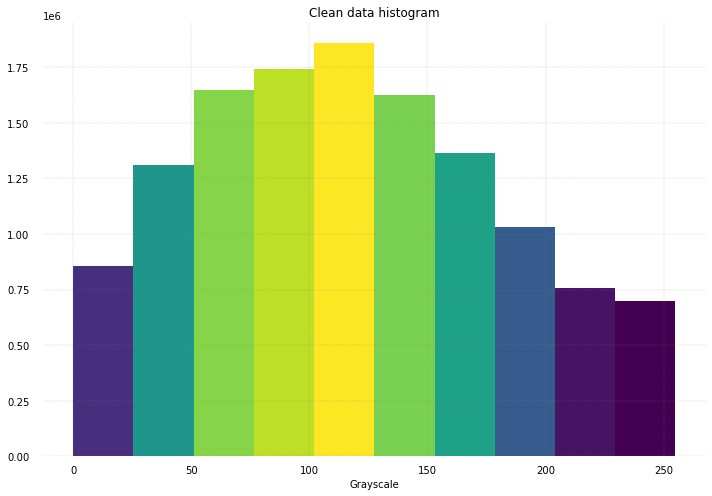

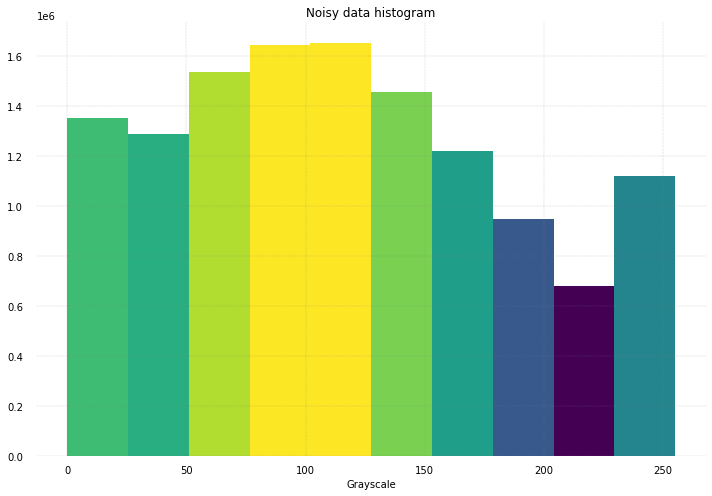

In [32]:
def plot_histogram_of_ds(data, title):
    
    fig, axs = plt.subplots(1, 1,
                            figsize =(10, 7),
                            tight_layout = True)

    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        axs.spines[s].set_visible(False)

    # Remove x, y ticks
    axs.xaxis.set_ticks_position('none')
    axs.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    axs.xaxis.set_tick_params(pad = 5)
    axs.yaxis.set_tick_params(pad = 10)

    # Add x, y gridlines
    axs.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.3,
            alpha = 0.6)

    # Creating histogram
    n, bins, patches = axs.hist(np.reshape(data, (data.shape[0]* resize_images_to**2)))

    col = (n-n.min())/(n.max()-n.min())
    cm = plt.cm.get_cmap('viridis')
    
    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))
    plt.xlabel("Grayscale")
    plt.title(title)

    # Show plot
    plt.show()
    

plot_histogram_of_ds(clean_images, 'Clean data histogram')
plot_histogram_of_ds(noisy_images, 'Noisy data histogram')

# Example images

0.0


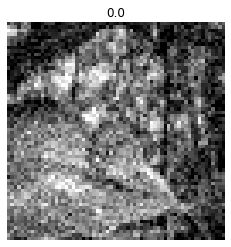

1.0


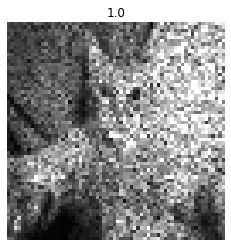

2.0


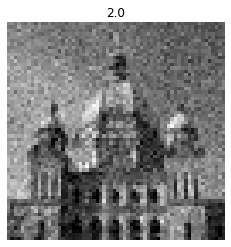

3.0


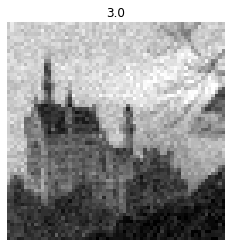

In [33]:
noise_types = y_noise_info[:,0]
labels_unique = np.unique(noise_types)

 
# set up the matplotlib figure and axes, based on the number of labels
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for label in labels_unique:
    fig, axes = plt.subplots(1, 1)
    idx = np.where(noise_types == label)
    print(label)
    axes.imshow(X_train[idx[0][1]],cmap='gray')
    axes.axis('off')
    axes.set_title(label)
    plt.show()

## PSNR

In [57]:
psnr_gaussian = np.array([], dtype=float,)
psnr_sp = np.array([], dtype=float,)
psnr_speckle = np.array([], dtype=float,)
boxplot_psnr = [psnr_gaussian, psnr_sp, psnr_speckle]
for l in range(3):
    ix=np.where(y_noise_info[:,0] == l)
    for index in ix[0]:
        psnr = calculate_psnr_ds(y[index], X[index])
        boxplot_psnr[l] = np.append(boxplot_psnr[l], psnr)
        


In [ ]:
fig = plt.figure(figsize =(10, 7))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot(boxplot_psnr)
# show plot
plt.show()

# Images per noise type

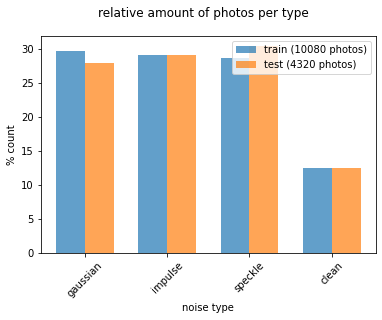

In [767]:
def plot_bar(y, loc='left', relative=True, xlabel='noise type'):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = ['gaussian', 'impulse', 'speckle', 'clean']
     
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel_text)
    
plt.suptitle('relative amount of photos per type')
plot_bar(y_train[:,0], loc='left')
plot_bar(y_test[:,0], loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
])

# Images per noise var

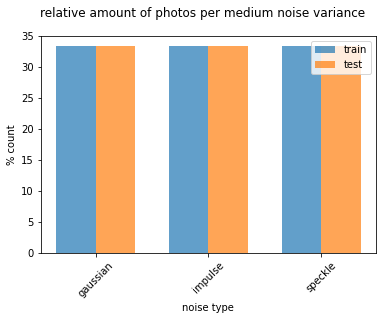

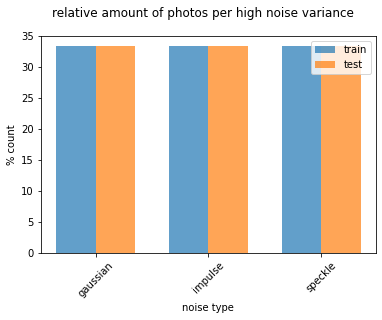

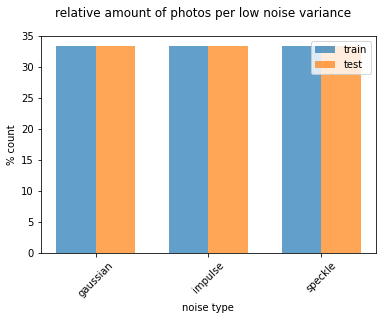

In [757]:
def plot_bar(y, loc='left', relative=True, xlabel='noise type'):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
    x = ['gaussian', 'impulse', 'speckle']
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
     
    counts = 100*counts[sorted_index]/len(y)
    ylabel_text = '% count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, x, rotation=45)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel_text)
for var in VALID_NOISE_STRENGHTS:
    values = noise_dictionary.get(var)
    idx=np.array([])
    idx_test=np.array([])
    count_g = np.where((y_train[:,0] == 0) & ((y_train[:,1] >= min_v) | (y_train[:,1] <= max_v)))[0].size
    count_i = np.where((y_train[:,0] == 1) & ((y_train[:,1] >= min_v) | (y_train[:,1] <= max_v)))[0].size
    count_sp = np.where((y_train[:,0] == 2) & ((y_train[:,1] >= min_v) | (y_train[:,1] <= max_v)))[0].size

    count_g_t = np.where((y_test[:,0] == 0) & ((y_test[:,1] >= min_v) | (y_test[:,1] <= max_v)))[0].size
    count_i_t = np.where((y_test[:,0] == 1) & ((y_test[:,1] >= min_v) | (y_test[:,1] <= max_v)))[0].size
    count_sp_t = np.where((y_test[:,0] == 2) & ((y_test[:,1] >= min_v) | (y_test[:,1] <= max_v)))[0].size

    plot_bar([count_g, count_i, count_sp], loc='left')
    plot_bar([count_g_t, count_i_t, count_sp_t], loc='right')
    plt.suptitle('relative amount of photos per {0} noise variance'.format(var))
    plt.legend([
        'train', 
        'test'
    ])
    plt.show()